In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'laptop-price-prediction-cleaned-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3408087%2F5937858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T151654Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9a676b0e3a49db9e9b2bb5b68f7c00a9ac7c06259a8d0425ab862e67f83e514a73127d9e7a4cfff0a750d93c348368679f15fce4e73feebc469c89532bcf4e99c845b25c54d30da200d5be83bf7411829ed1fcd94780b3bb0d711f9d14d01f828b474366e1ee81ab12bb6ebc1f2ff34c6fd4fbe30a7853959cb1f528d083fba1f95b83cd6515103931bde1e7e58483e96932f8744c7150ef3e5931ba857f3eb19de80e729a02e63a6dede95e158410237bac86aeea2d4d0f332e1b5a7a204de5a0fdd12c8896e601b19340d3737696e3d6f5e347fc507156260733ec064e2a78e09ba24aa259f38806116430a8bf054a96ed6516242d46b623161ed8e32d5d64'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install optuna
!pip install hyperopt

In [ ]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import glob
import shap
shap.initjs()
import tabulate
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from optuna import create_study
from hyperopt import hp, fmin, tpe, Trials

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, silhouette_score

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
# Load data

data = pd.read_csv(glob.glob("/kaggle/input/laptop-price-prediction-cleaned-dataset/*.csv")[0])

print(data.shape)

data.head()

(1273, 13)


Company   TypeName  Ram  Weight      Price  TouchScreen  Ips         Ppi  \
0   Apple  Ultrabook    8    1.37  11.175755            0    1  226.983005   
1   Apple  Ultrabook    8    1.34  10.776777            0    0  127.677940   
2      HP   Notebook    8    1.86  10.329931            0    0  141.211998   
3   Apple  Ultrabook   16    1.83  11.814476            0    1  220.534624   
4   Apple  Ultrabook    8    1.37  11.473101            0    1  226.983005   

       Cpu_brand  HDD  SSD Gpu_brand      Os  
0  Intel Core i5    0  128     Intel     Mac  
1  Intel Core i5    0    0     Intel     Mac  
2  Intel Core i5    0  256     Intel  Others  
3  Intel Core i7    0  512       AMD     Mac  
4  Intel Core i5    0  256     Intel     Mac

In [ ]:
# Check dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273 entries, 0 to 1272
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1273 non-null   object 
 1   TypeName     1273 non-null   object 
 2   Ram          1273 non-null   int64  
 3   Weight       1273 non-null   float64
 4   Price        1273 non-null   float64
 5   TouchScreen  1273 non-null   int64  
 6   Ips          1273 non-null   int64  
 7   Ppi          1273 non-null   float64
 8   Cpu_brand    1273 non-null   object 
 9   HDD          1273 non-null   int64  
 10  SSD          1273 non-null   int64  
 11  Gpu_brand    1273 non-null   object 
 12  Os           1273 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 129.4+ KB


In [ ]:
# Check the descriptive statistics of the numerical features
data.describe().T.style.background_gradient(cmap="viridis")

In [ ]:
# Check the descriptive statistics of the categorical features
data.describe(include="O").T

count unique            top  freq
Company    1273     19           Dell   291
TypeName   1273      6       Notebook   706
Cpu_brand  1273      5  Intel Core i7   515
Gpu_brand  1273      3          Intel   703
Os         1273      3        Windows  1100

In [ ]:
# cCheck the number of unique values each columns has
data.nunique()

Company         19
TypeName         6
Ram              9
Weight         171
Price          791
TouchScreen      2
Ips              2
Ppi             39
Cpu_brand        5
HDD              6
SSD             13
Gpu_brand        3
Os               3
dtype: int64

In [ ]:
# Check for presence of null values
data.isnull().sum()

Company        0
TypeName       0
Ram            0
Weight         0
Price          0
TouchScreen    0
Ips            0
Ppi            0
Cpu_brand      0
HDD            0
SSD            0
Gpu_brand      0
Os             0
dtype: int64

## EDA

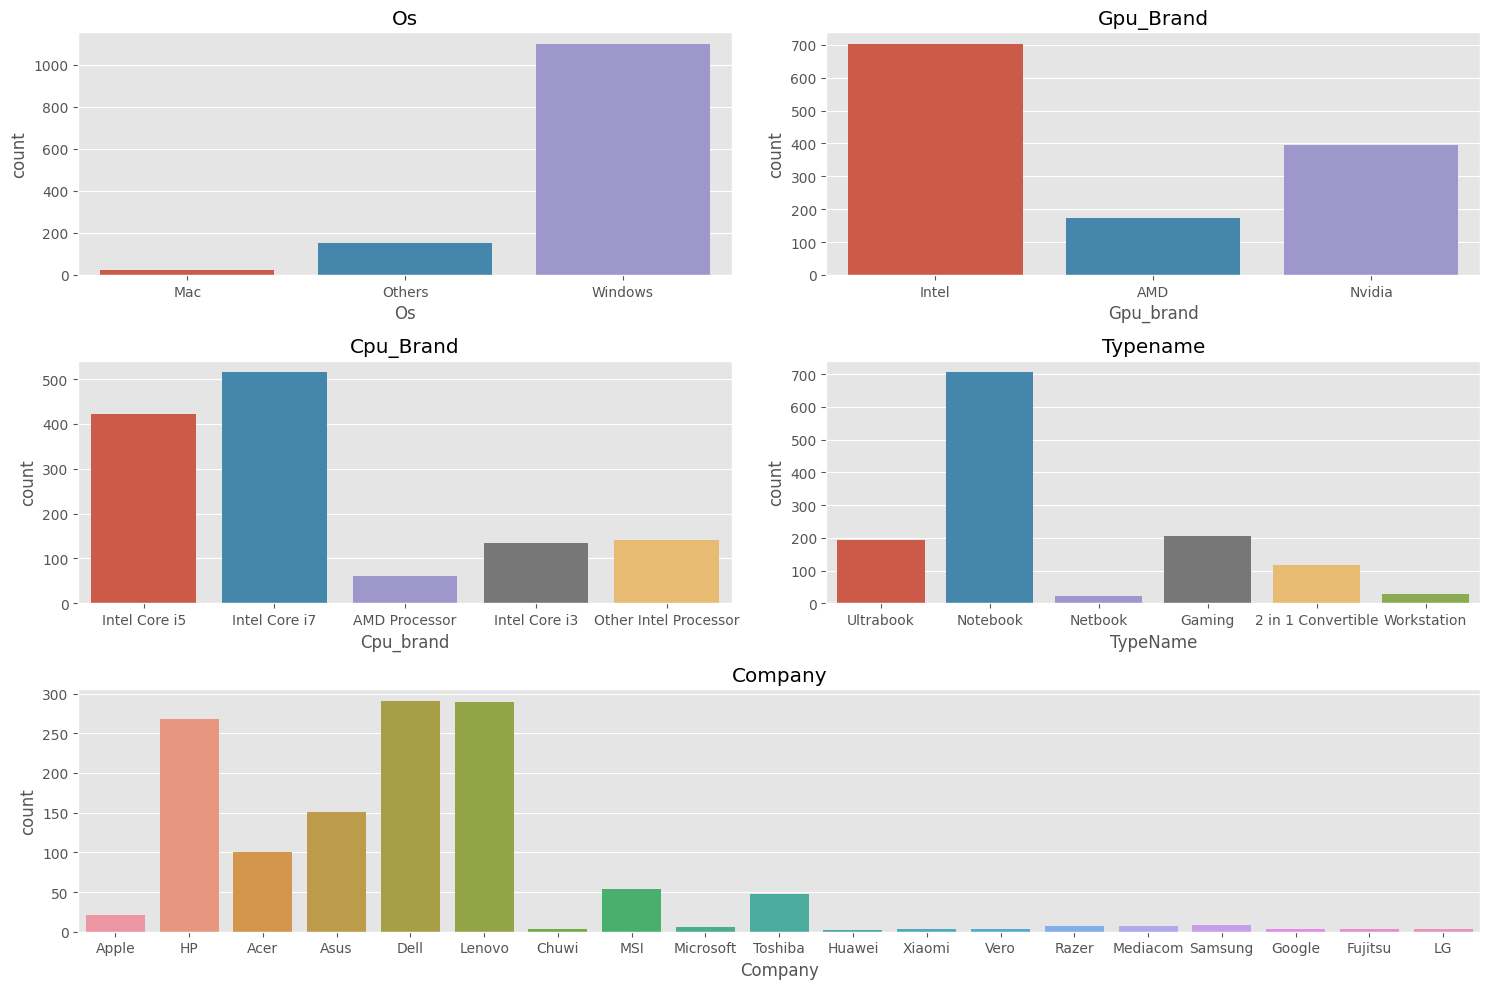

In [ ]:
figa, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
ax = ax.flatten()

for index, col in enumerate(data.select_dtypes(include="O").columns[::-1]):
    countplot = sns.countplot(data=data, x=col, ax=ax[index])
    countplot.set_title(col.title())

for del_ax in ax[len(data.select_dtypes(include="O").columns):]:
    plt.delaxes(del_ax)

plt.subplot(3, 1, 3)
sns.countplot(data=data, x=data.select_dtypes(include="O").columns[0])
plt.title(data.select_dtypes(include="O").columns[0])

plt.tight_layout()
plt.show()

## Observation:
* Inbalance Distribution of Companies
* Inbalance Dustribution of OS
* In the **Cpu_Brand** column, there are more of Intel Core i7 and Intel Core i5
* In **Typename** Column, we have more of notebook

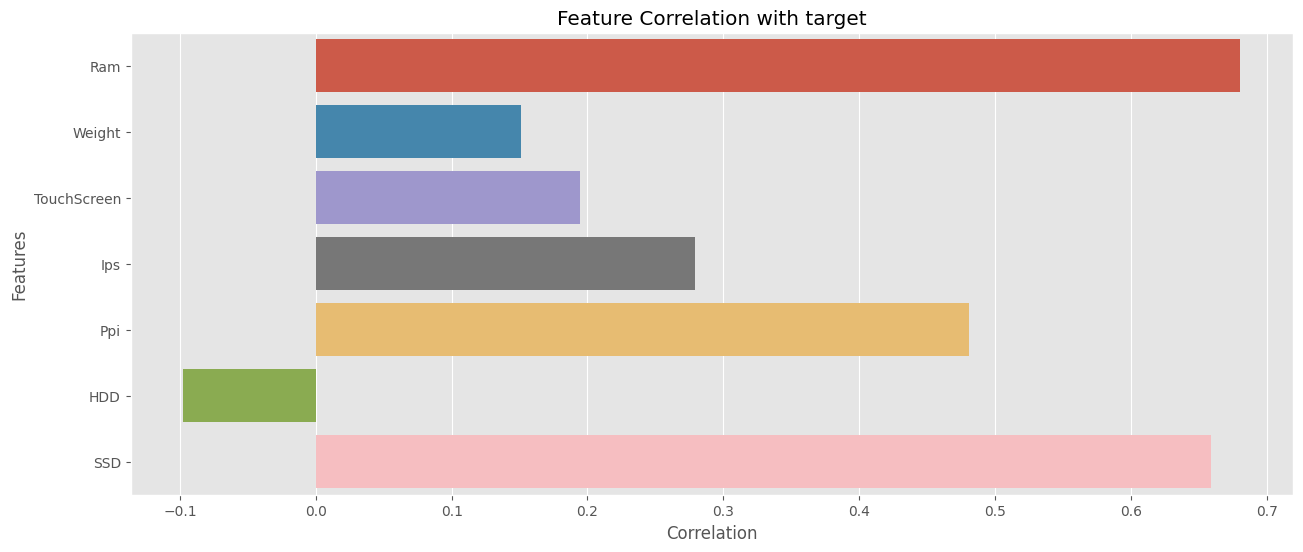

In [ ]:
num_feat_corr = data.select_dtypes(exclude="O").corr()["Price"]
num_feat_corr = pd.Series(dict([(idx, val) for idx, val in zip(num_feat_corr.index, num_feat_corr.values) if idx != "Price"]))

plt.figure(figsize=(15, 6))
sns.barplot(x=num_feat_corr.values, y=num_feat_corr.index)
plt.title("Feature Correlation with target")
plt.xlabel("Correlation")
plt.ylabel("Features")

plt.show()

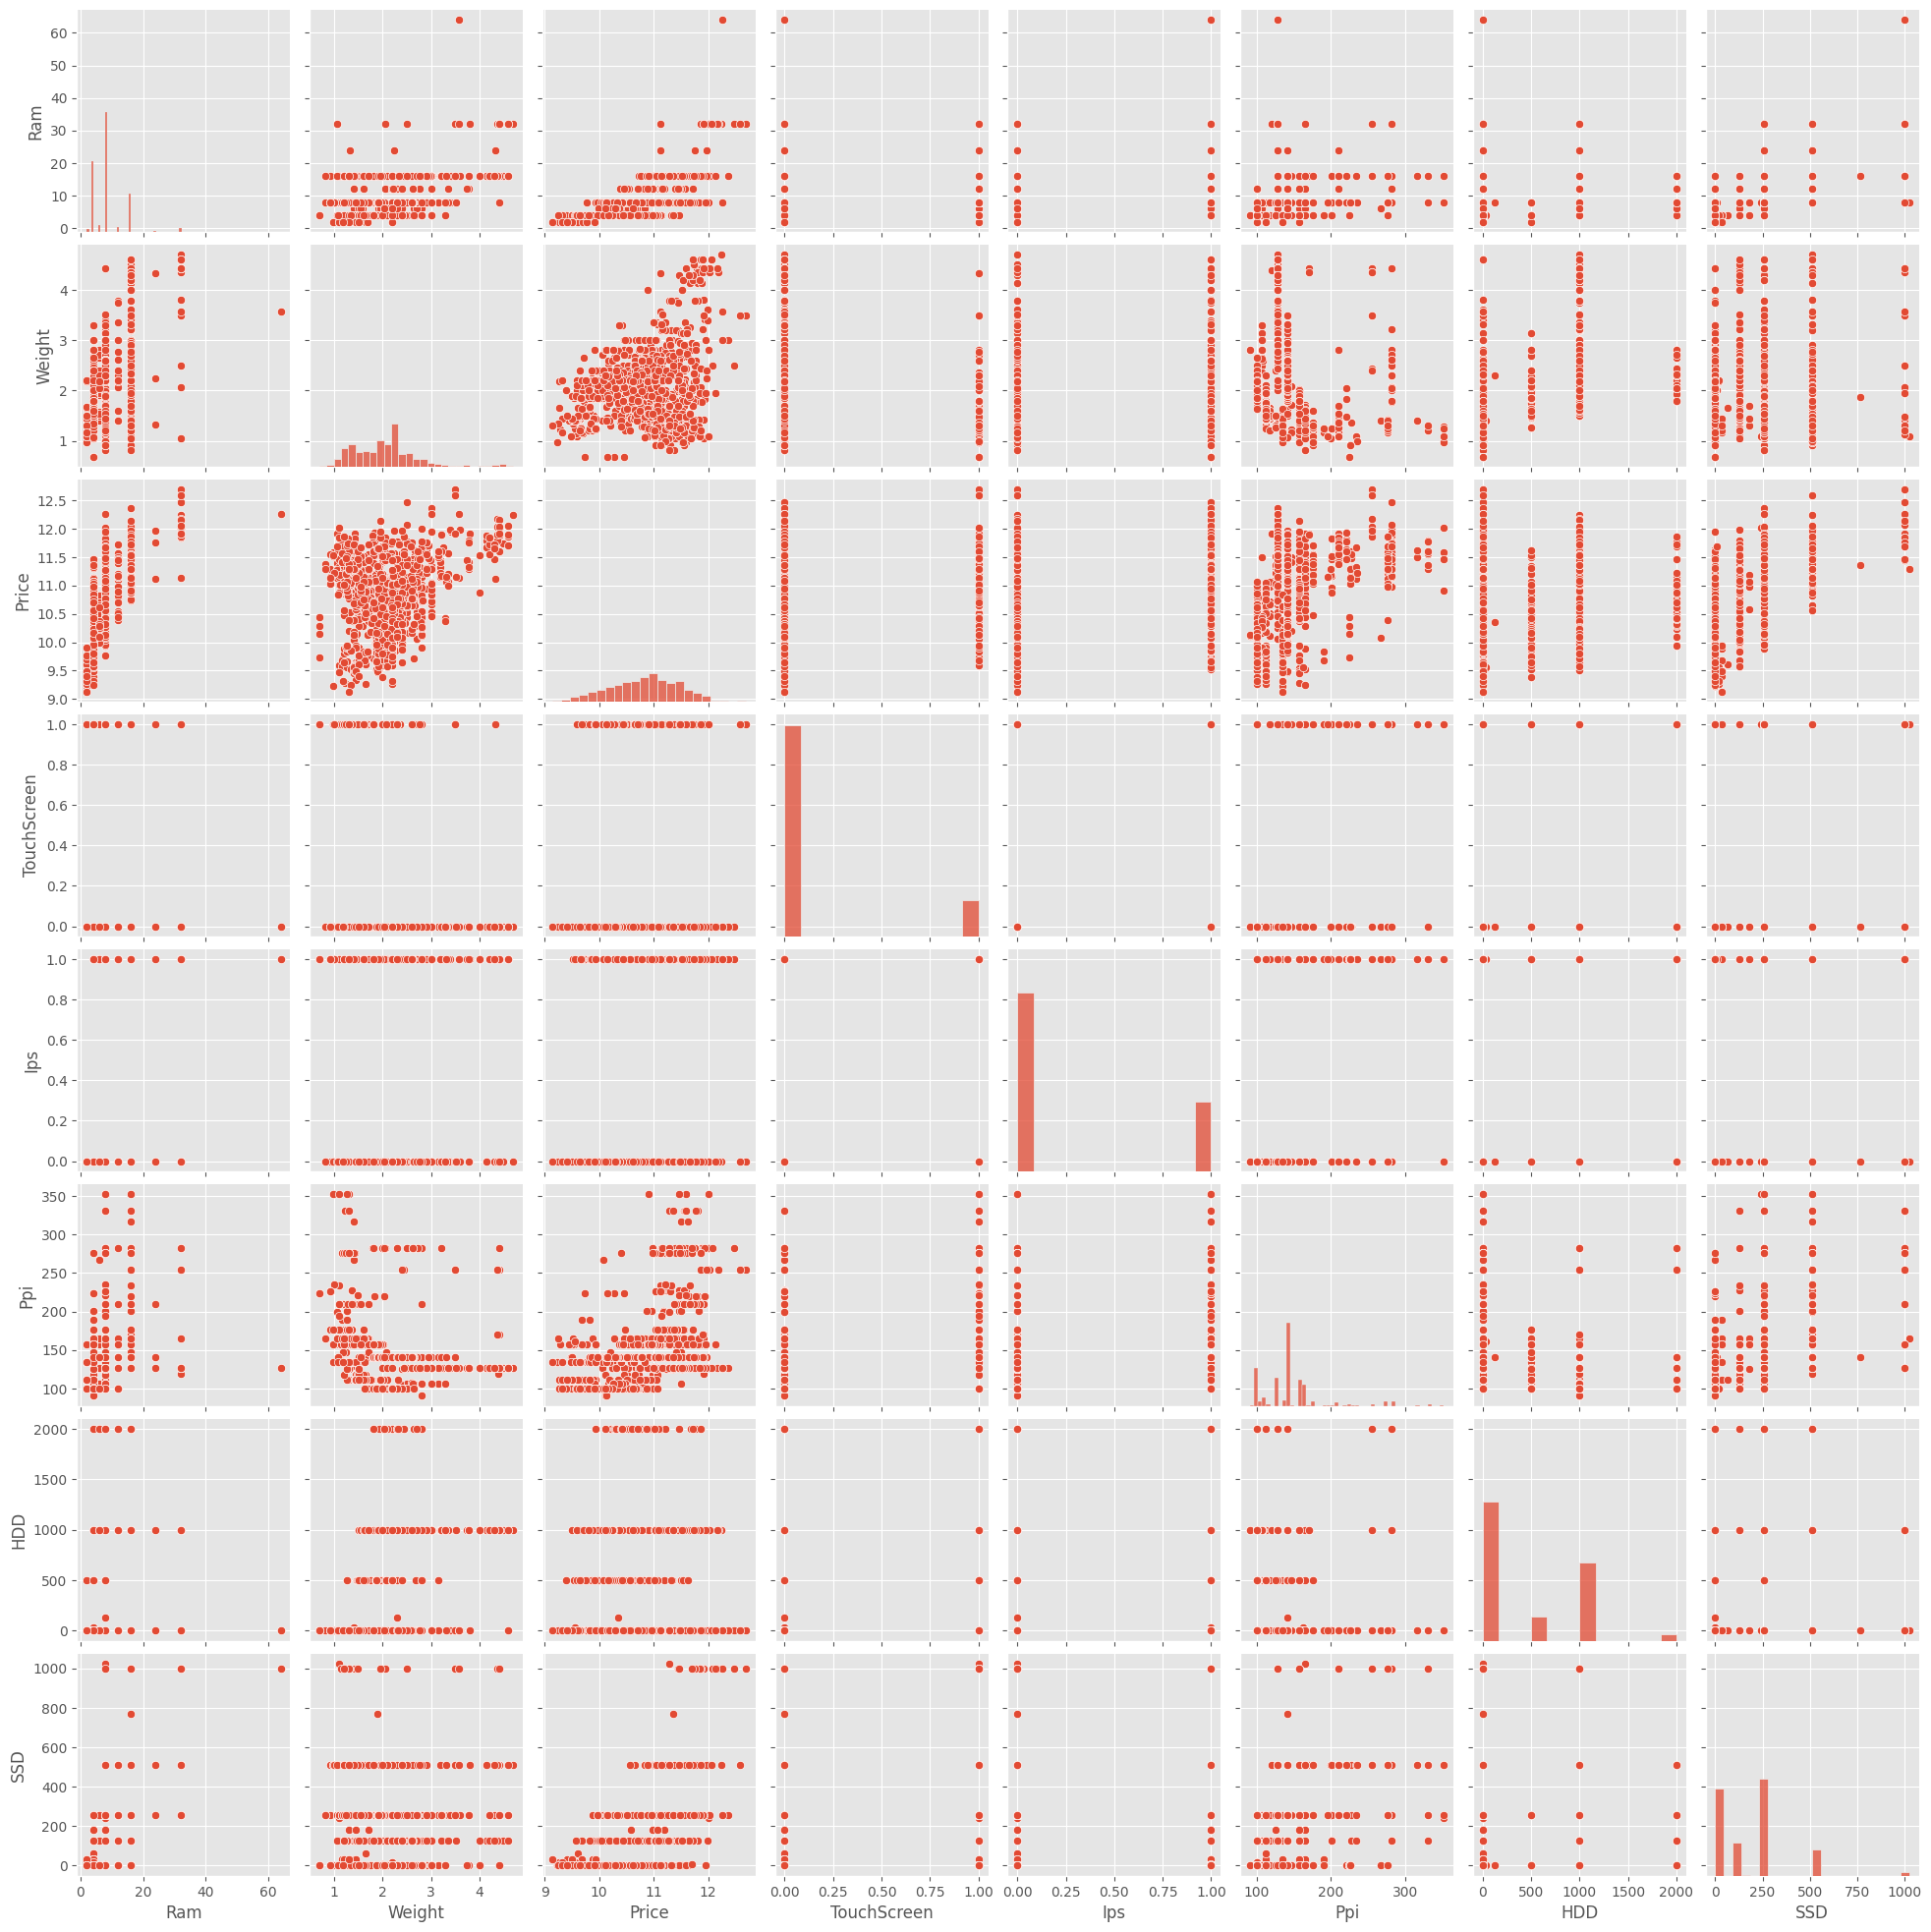

In [ ]:
sns.pairplot(data.select_dtypes(exclude="O"))
plt.show()

## Baseline Models

In [ ]:
base_data = data.copy()
encoder = LabelEncoder()
cat_col = base_data.select_dtypes(include="O").columns

for col in cat_col:
    base_data[col] = encoder.fit_transform(base_data[col])

In [ ]:
scaler = StandardScaler()

y = base_data.pop("Price")
X = pd.DataFrame(scaler.fit_transform(base_data), columns=base_data.columns)

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

Xtrain.shape, Xtest.shape

((1018, 12), (255, 12))

In [ ]:
list_of_algo = [DecisionTreeRegressor, MLPRegressor, KNeighborsRegressor, RandomForestRegressor, LinearRegression, SGDRegressor, Ridge, Lasso, XGBRegressor, CatBoostRegressor, LGBMRegressor]

In [ ]:
result = {"Model Name":[], "RMSE":[], "MAE":[], "MAPE":[]}
feature_imp = {"Model Name": [], "Feature Importance": []}

for algo in tqdm(list_of_algo, desc="Training models", total=len(list_of_algo)):
    if algo.__name__ == "LGBMRegressor":
        algo_ = algo(verbosity=-1)
    elif algo.__name__ == "CatBoostRegressor":
        algo_ = algo(verbose=0)
    elif algo.__name__ == "XGBRegressor":
        algo_ = algo(silent=True)
    else:
        algo_ = algo()
    algo_.fit(Xtrain, ytrain)
    pred = algo_.predict(Xtest)

    result["Model Name"].append(algo.__name__)
    result["RMSE"].append(np.sqrt(mean_squared_error(ytest, pred)))
    result["MAE"].append(mean_absolute_error(ytest, pred))
    result["MAPE"].append(mean_absolute_percentage_error(ytest, pred))

    if algo.__name__ in ["LGBMRegressor", "CatBoostRegressor", "XGBRegressor"]:
        feature_imp["Model Name"].append(algo.__name__)
        feature_imp["Feature Importance"].append(algo_.feature_importances_)

print(tabulate.tabulate(result, headers=["Model Name", "RMSE", "MAE", "MAPE"], tablefmt="double_grid"))

Training models: 100%|██████████| 11/11 [00:02<00:00,  3.76it/s]

╔═══════════════════════╦══════════╦══════════╦═══════════╗
║ Model Name            ║     RMSE ║      MAE ║      MAPE ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ DecisionTreeRegressor ║ 0.311434 ║ 0.224666 ║ 0.0208533 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ MLPRegressor          ║ 0.723736 ║ 0.562486 ║ 0.0524405 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ KNeighborsRegressor   ║ 0.26534  ║ 0.196694 ║ 0.0183205 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ RandomForestRegressor ║ 0.249937 ║ 0.180061 ║ 0.0167816 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ LinearRegression      ║ 0.354286 ║ 0.282903 ║ 0.0264236 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ SGDRegressor          ║ 0.353479 ║ 0.283578 ║ 0.0265231 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ Ridge                 ║ 0.354263 ║ 0.282882 ║ 0.0264222 ║
╠═══════════════════════╬══════════╬════

## Feature Importance

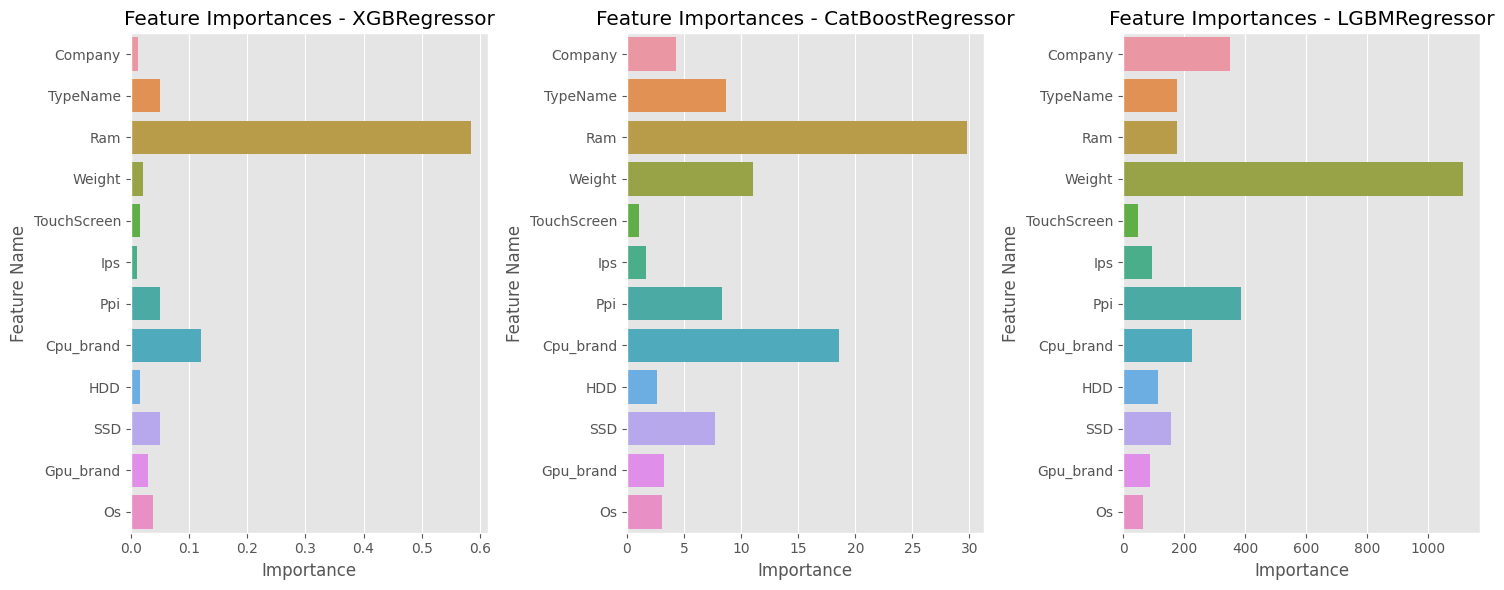

In [ ]:
plt.figure(figsize=(15, 6))

for index, (model_name, importances) in enumerate(zip(feature_imp["Model Name"], feature_imp["Feature Importance"]), start=1):
    plt.subplot(1, 3, index)
    sns.barplot(x=importances, y=Xtrain.columns)
    plt.title(f"Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature Name")

plt.tight_layout()
plt.show()

## Feature Selection

In [ ]:
xgbreg_feat_sel = SelectFromModel(estimator=XGBRegressor())

xgbreg_feat_sel.fit(Xtrain, ytrain)

selected_feature_indices = xgbreg_feat_sel.get_support(indices=True)

selected_feature_names = Xtrain.columns[selected_feature_indices]

selected_feature_names

Index(['Ram', 'Cpu_brand'], dtype='object')

In [ ]:
ctbreg_feat_sel = SelectFromModel(estimator=CatBoostRegressor(verbose=0))

ctbreg_feat_sel.fit(Xtrain, ytrain)

selected_feature_indices = ctbreg_feat_sel.get_support(indices=True)

selected_feature_names = Xtrain.columns[selected_feature_indices]

selected_feature_names

Index(['TypeName', 'Ram', 'Weight', 'Cpu_brand'], dtype='object')

In [ ]:
lgmbreg_feat_sel = SelectFromModel(estimator=LGBMRegressor(verbosity=-1))

lgmbreg_feat_sel.fit(Xtrain, ytrain)

selected_feature_indices = lgmbreg_feat_sel.get_support(indices=True)

selected_feature_names = Xtrain.columns[selected_feature_indices]

selected_feature_names

Index(['Company', 'Weight', 'Ppi'], dtype='object')

## Model Explainability

### XGBRegressor

In [ ]:
xgb_reg = XGBRegressor()

xgb_reg.fit(Xtrain, ytrain)

xgb_explainer = shap.TreeExplainer(model=xgb_reg)

xgb_shap_val = xgb_explainer.shap_values(Xtrain)

shap.force_plot(xgb_explainer.expected_value, xgb_shap_val[1, :], Xtrain.iloc[1, :])

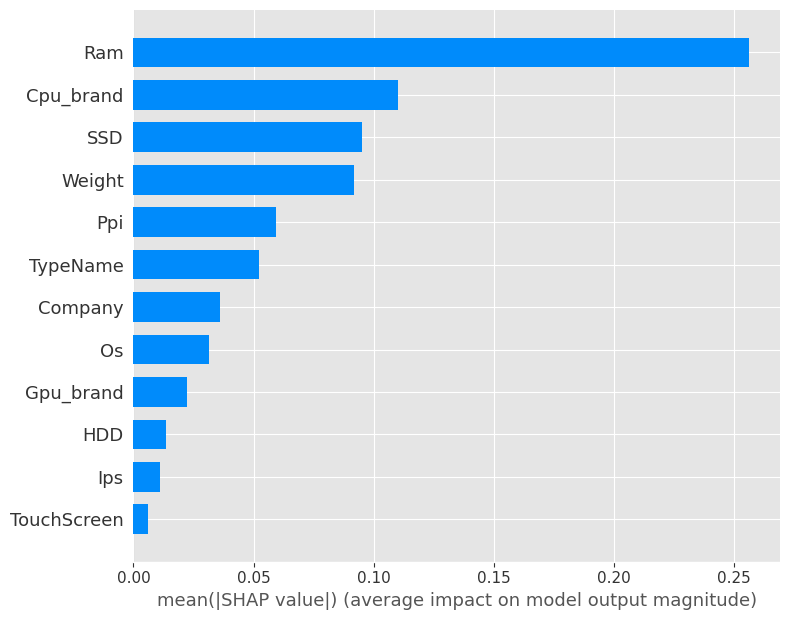

In [ ]:
shap.summary_plot(xgb_shap_val, Xtrain, plot_type="bar")

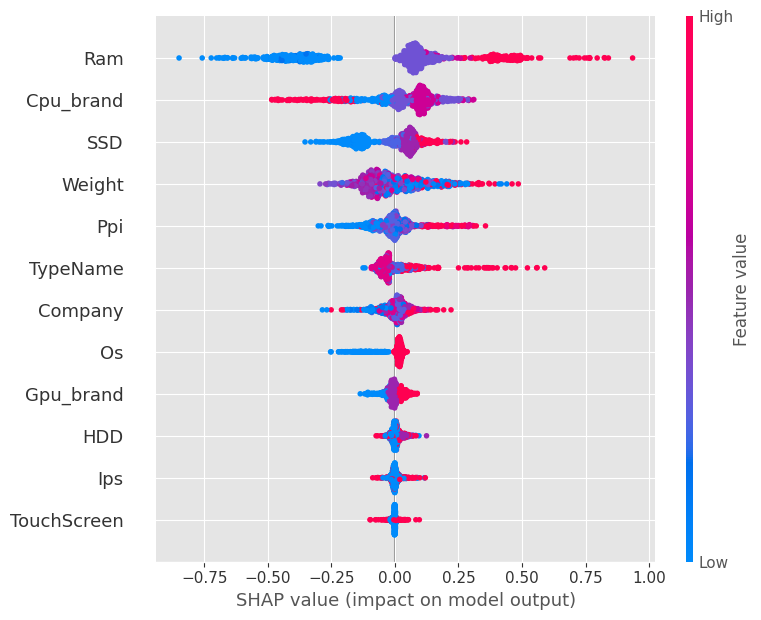

In [ ]:
shap.summary_plot(xgb_shap_val, Xtrain)

### CatBoostRegressor

In [ ]:
ct_reg = CatBoostRegressor(verbose=0)

ct_reg.fit(Xtrain, ytrain)

ct_explainer = shap.TreeExplainer(model=ct_reg)

ct_shap_val = ct_explainer.shap_values(Xtrain)

shap.force_plot(ct_explainer.expected_value, ct_shap_val[1, :], Xtrain.iloc[1, :])

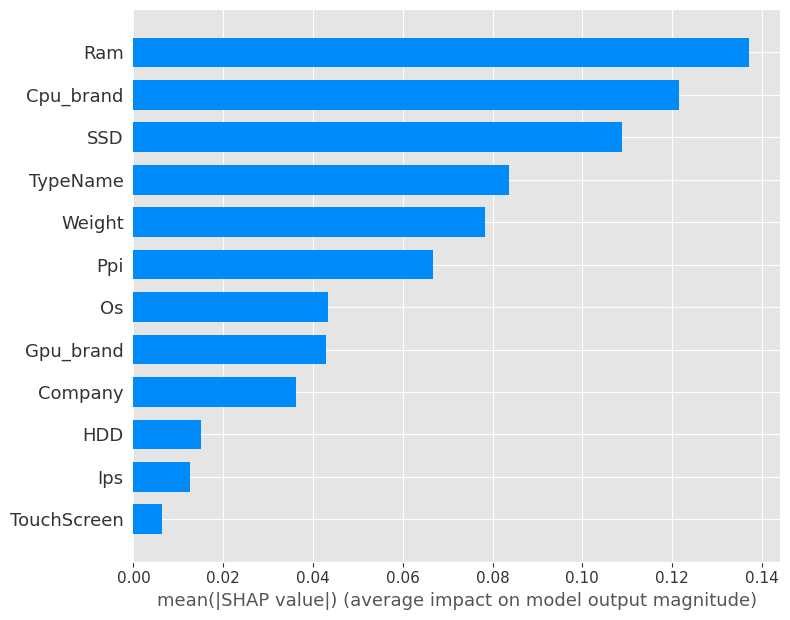

In [ ]:
shap.summary_plot(ct_shap_val, Xtrain, plot_type="bar")

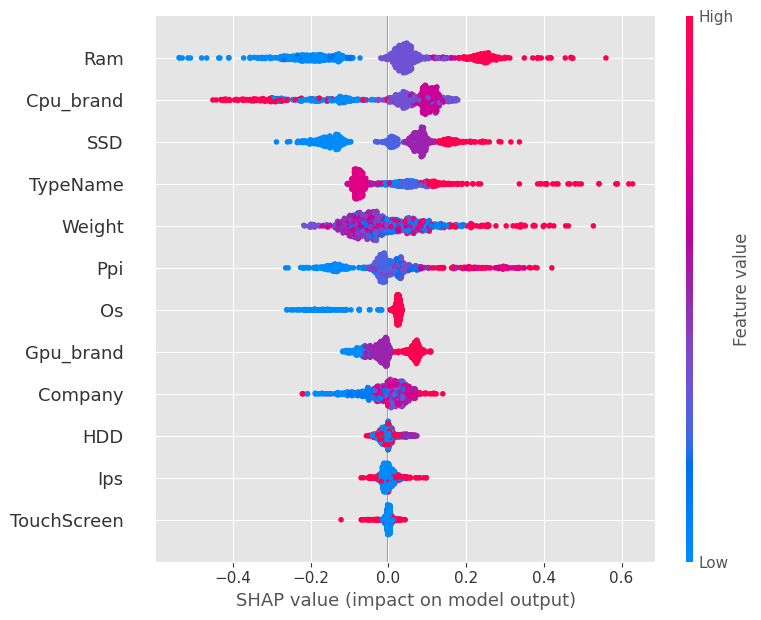

In [ ]:
shap.summary_plot(ct_shap_val, Xtrain)

### LGBMRegressor

In [ ]:
lgbm_reg = LGBMRegressor(verbose=0)

lgbm_reg.fit(Xtrain, ytrain)

lgbm_explainer = shap.TreeExplainer(model=lgbm_reg)

lgbm_shap_val = lgbm_explainer.shap_values(Xtrain)

shap.force_plot(lgbm_explainer.expected_value, lgbm_shap_val[2, :], Xtrain.iloc[2, :])

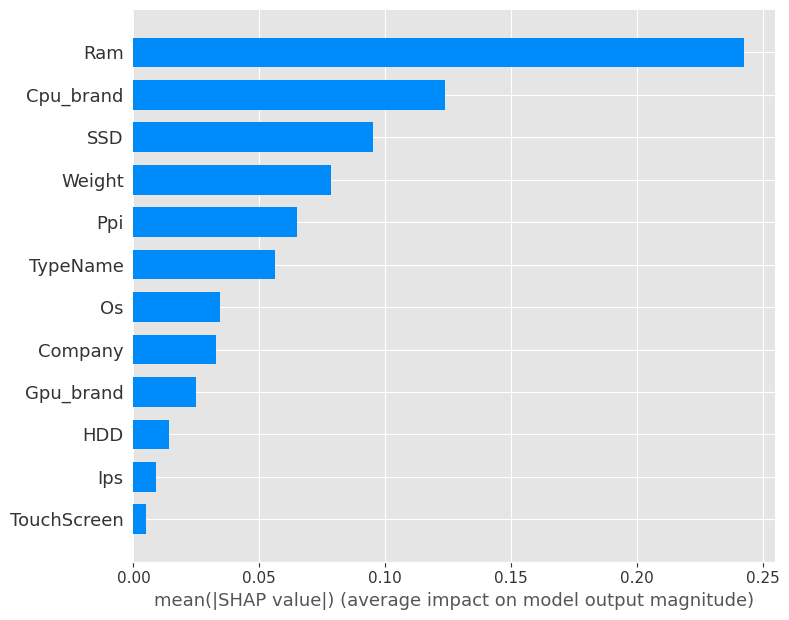

In [ ]:
shap.summary_plot(lgbm_shap_val, Xtrain, plot_type="bar")

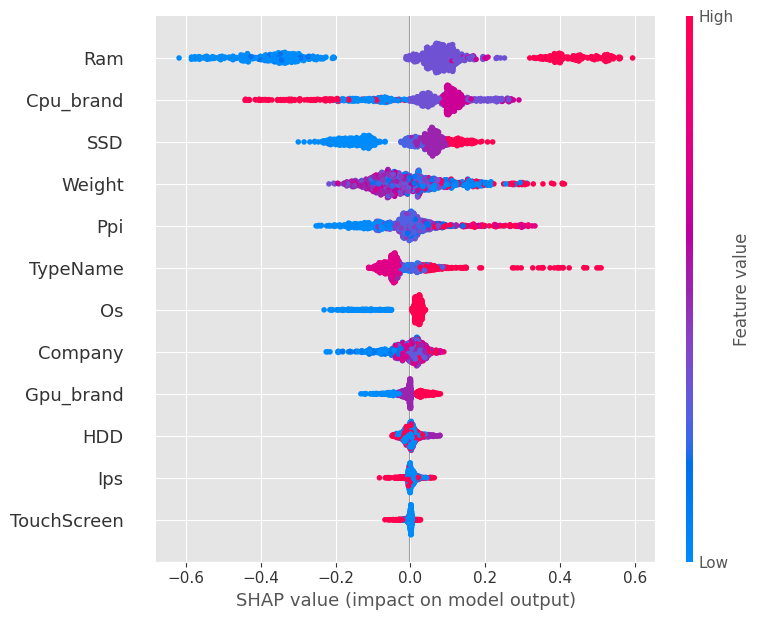

In [ ]:
shap.summary_plot(lgbm_shap_val, Xtrain)

In [ ]:
def Model_CrossValidation(list_of_model, X, y):
    kfold = KFold(n_splits=5)
    result = {"Model Name":[], "RMSE":[], "MAE":[], "MAPE":[]}

    for algo in list_of_model:
        if algo.__name__ == "LGBMRegressor":
            algo_ = algo(verbosity=-1)
        elif algo.__name__ == "CatBoostRegressor":
            algo_ = algo(verbose=0)
        elif algo.__name__ == "XGBRegressor":
            algo_ = algo(silent=True)
        else:
            algo_ = algo()

        score_per_fold = {"Model Name":[], "RMSE":[], "MAE":[], "MAPE":[]}
        for train_idx, test_idx in tqdm(kfold.split(X, y), total=kfold.n_splits, desc=f"Training {algo.__name__}"):
            xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
            xtest, ytest = X.iloc[test_idx], y.iloc[test_idx]

            algo_.fit(xtrain, ytrain)

            pred = algo_.predict(xtest)

            score_per_fold["RMSE"].append(np.sqrt(mean_squared_error(ytest, pred)))
            score_per_fold["MAE"].append(mean_absolute_error(ytest, pred))
            score_per_fold["MAPE"].append(mean_absolute_percentage_error(ytest, pred))

        result["Model Name"].append(algo.__name__)
        result["RMSE"].append(np.mean(score_per_fold["RMSE"]))
        result["MAE"].append(np.mean(score_per_fold["MAE"]))
        result["MAPE"].append(np.mean(score_per_fold["MAPE"]))

    print(tabulate.tabulate(result, headers=["Model Name", "RMSE", "MAE", "MAPE"], tablefmt="double_grid"))

In [ ]:
Model_CrossValidation(list_of_algo, X, y)

Training LGBMRegressor: 100%|██████████| 5/5 [00:00<00:00, 13.67it/s]

╔═══════════════════════╦══════════╦══════════╦═══════════╗
║ Model Name            ║     RMSE ║      MAE ║      MAPE ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ DecisionTreeRegressor ║ 0.30234  ║ 0.224255 ║ 0.0206641 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ MLPRegressor          ║ 0.816904 ║ 0.615472 ║ 0.0571375 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ KNeighborsRegressor   ║ 0.281856 ║ 0.210221 ║ 0.0194358 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ RandomForestRegressor ║ 0.233497 ║ 0.177383 ║ 0.0163768 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ LinearRegression      ║ 0.389034 ║ 0.310842 ║ 0.0288259 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ SGDRegressor          ║ 0.390759 ║ 0.311829 ║ 0.0289189 ║
╠═══════════════════════╬══════════╬══════════╬═══════════╣
║ Ridge                 ║ 0.389009 ║ 0.310829 ║ 0.0288253 ║
╠═══════════════════════╬══════════╬════

## Hyperparameter Tuning

### Optuna

In [ ]:
def Optimize_Model(trial, X, y):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
    }
    kfold = KFold(n_splits=5)
    model = CatBoostRegressor(**params)
    score_per_fold = {"RMSE":[], "MAE":[], "MAPE":[]}
    for train_idx, test_idx in tqdm(kfold.split(X, y), total=kfold.n_splits, desc=f"Training {algo.__name__}"):
        xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
        xtest, ytest = X.iloc[test_idx], y.iloc[test_idx]

        algo_.fit(xtrain, ytrain)

        pred = algo_.predict(xtest)

        score_per_fold["RMSE"].append(np.sqrt(mean_squared_error(ytest, pred)))
        score_per_fold["MAE"].append(mean_absolute_error(ytest, pred))
        score_per_fold["MAPE"].append(mean_absolute_percentage_error(ytest, pred))

    mean_RMSE = np.mean(score_per_fold["RMSE"])
    mean_MAE = np.mean(score_per_fold["MAE"])
    mean_MAPE = np.mean(score_per_fold["MAPE"])

    combined_score = (mean_RMSE + mean_MAE + mean_MAPE) / 3.0

    return combined_score

In [ ]:
func = partial(Optimize_Model, X=X, y=y)

study = create_study(direction="minimize")

study.optimize(func=func, n_trials=100)

[I 2024-04-01 13:13:47,568] A new study created in memory with name: no-name-0e09450d-77d3-42ed-9c79-1779f8396f83
Training LGBMRegressor: 100%|██████████| 5/5 [00:00<00:00, 14.19it/s]
[I 2024-04-01 13:13:47,926] Trial 0 finished with value: 0.1393820923500168 and parameters: {'learning_rate': 0.04423606095727785, 'depth': 11, 'l2_leaf_reg': 6.982231744890303, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.1393820923500168.
Training LGBMRegressor: 100%|██████████| 5/5 [00:00<00:00, 13.82it/s]
[I 2024-04-01 13:13:48,293] Trial 1 finished with value: 0.1393820923500168 and parameters: {'learning_rate': 0.0438901959836784, 'depth': 8, 'l2_leaf_reg': 6.839868320191732, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.1393820923500168.
Training LGBMRegressor: 100%|██████████| 5/5 [00:00<00:00, 14.01it/s]
[I 2024-04-01 13:13:48,655] Trial 2 finished with value: 0.1393820923500168 and parameters: {'learning_rate': 0.059731745451321996, 'depth': 1, 'l2_leaf_reg': 2.3250538

In [ ]:
def Train_Model(X, y, params):
    kfold = KFold(n_splits=5)
    score_per_fold = {"RMSE": [], "MAE": [], "MAPE": []}
    for train_idx, test_idx in tqdm(kfold.split(X, y), total=kfold.n_splits, desc="Training..."):
        xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
        xtest, ytest = X.iloc[test_idx], y.iloc[test_idx]

        model = CatBoostRegressor(**params, verbose=False)
        model.fit(xtrain, ytrain)
        pred = model.predict(xtest)

        score_per_fold["RMSE"].append(np.sqrt(mean_squared_error(ytest, pred)))
        score_per_fold["MAE"].append(mean_absolute_error(ytest, pred))
        score_per_fold["MAPE"].append(mean_absolute_percentage_error(ytest, pred))

    mean_rmse = np.mean(score_per_fold["RMSE"])
    mean_mae = np.mean(score_per_fold["MAE"])
    mean_mape = np.mean(score_per_fold["MAPE"])

    print(tabulate.tabulate([[mean_rmse, mean_mae, mean_mape]], headers=["RMSE", "MAE", "MAPE"], tablefmt="double_grid"))

    return model

In [ ]:
study.best_params

{'learning_rate': 0.04423606095727785,
 'depth': 11,
 'l2_leaf_reg': 6.982231744890303,
 'boosting_type': 'Ordered'}

In [ ]:
study.best_value

0.1393820923500168

In [ ]:
opt_model = Train_Model(X, y, study.best_params)

Training...: 100%|██████████| 5/5 [01:35<00:00, 19.19s/it]

╔══════════╦══════════╦═══════════╗
║     RMSE ║      MAE ║      MAPE ║
╠══════════╬══════════╬═══════════╣
║ 0.220615 ║ 0.170971 ║ 0.0157533 ║
╚══════════╩══════════╩═══════════╝


In [ ]:
def hyperopt_objective(params, X, y):
    kfold = KFold(n_splits=5)
    score_per_fold = {"RMSE": [], "MAE": [], "MAPE": []}
    for train_idx, test_idx in kfold.split(X, y):
        xtrain, ytrain = X.iloc[train_idx], y.iloc[train_idx]
        xtest, ytest = X.iloc[test_idx], y.iloc[test_idx]

        model = CatBoostRegressor(**params)
        model.fit(xtrain, ytrain, verbose=False)
        pred = model.predict(xtest)

        score_per_fold["RMSE"].append(np.sqrt(mean_squared_error(ytest, pred)))
        score_per_fold["MAE"].append(mean_absolute_error(ytest, pred))
        score_per_fold["MAPE"].append(mean_absolute_percentage_error(ytest, pred))

    mean_RMSE = np.mean(score_per_fold["RMSE"])
    mean_MAE = np.mean(score_per_fold["MAE"])
    mean_MAPE = np.mean(score_per_fold["MAPE"])

    combined_score = (mean_RMSE + mean_MAE + mean_MAPE) / 3.0

    return -combined_score

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'depth': hp.randint('depth', 1, 16),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
}

best = fmin(fn=partial(hyperopt_objective, X=X, y=y),
            space=space,
            algo=tpe.suggest,
            trials=Trials(),
            max_evals=20)

100%|██████████| 20/20 [45:36<00:00, 136.84s/trial, best loss: -0.1658578576888838]


In [ ]:
print(best)

{'boosting_type': 0, 'depth': 1, 'l2_leaf_reg': 2.5590579235756676, 'learning_rate': 0.051173346440673825}


In [ ]:
best = {i:j for i, j in best.items() if i != "boosting_type"}

In [ ]:
opt_model_hyp = Train_Model(X, y, best)

Training...: 100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

╔══════════╦══════════╦═══════════╗
║     RMSE ║      MAE ║      MAPE ║
╠══════════╬══════════╬═══════════╣
║ 0.261288 ║ 0.206093 ║ 0.0190463 ║
╚══════════╩══════════╩═══════════╝


## KMean Clustering

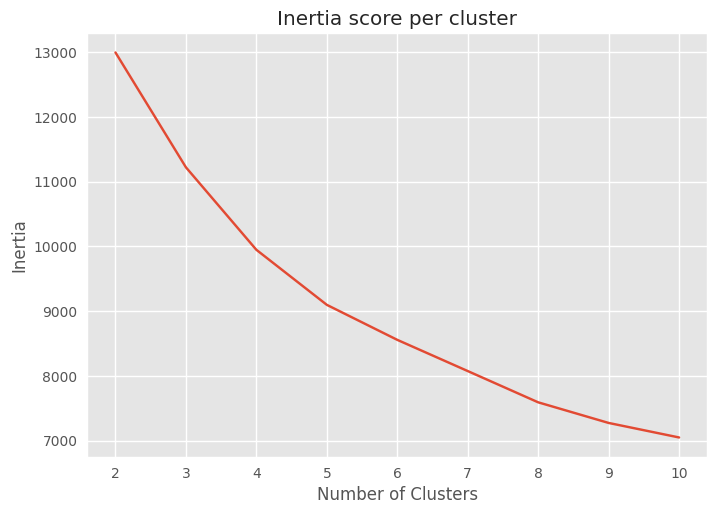

In [ ]:
inertia = []

for i in range(2, 11):
    kmean = KMeans(n_clusters=i)
    kmean.fit(X)
    inertia.append(kmean.inertia_)

plt.plot(range(2, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia score per cluster")
plt.show()

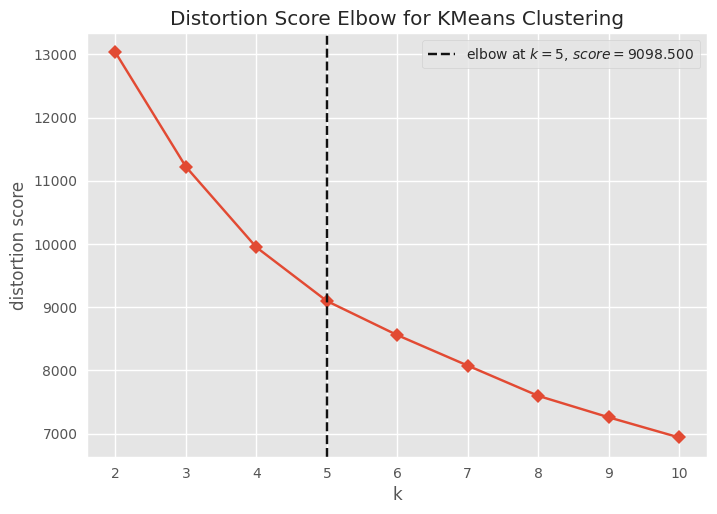

In [ ]:
kelbow_vis = KElbowVisualizer(estimator=KMeans(), k=range(2, 11), timings=False)

kelbow_vis.fit(X)

kelbow_vis.show()

plt.show()

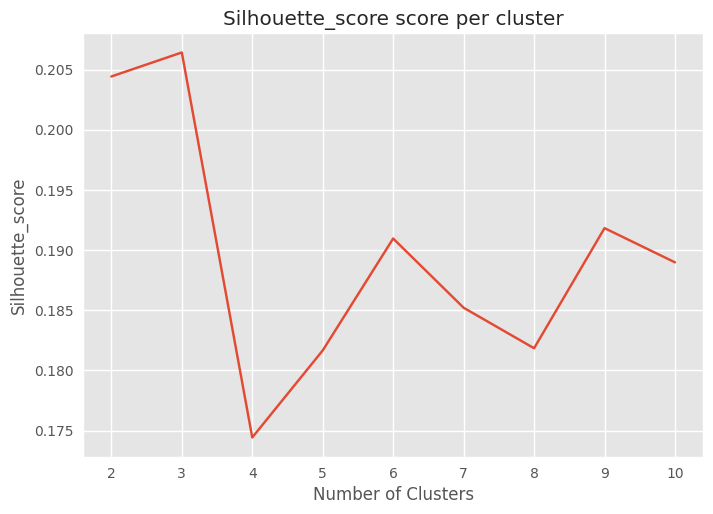

In [ ]:
s_s = []

for i in range(2, 11):
    kmean = KMeans(n_clusters=i)
    kmean.fit(X)
    s_s.append(silhouette_score(X, kmean.labels_))

plt.plot(range(2, 11), s_s)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette_score")
plt.title("Silhouette_score score per cluster")
plt.show()

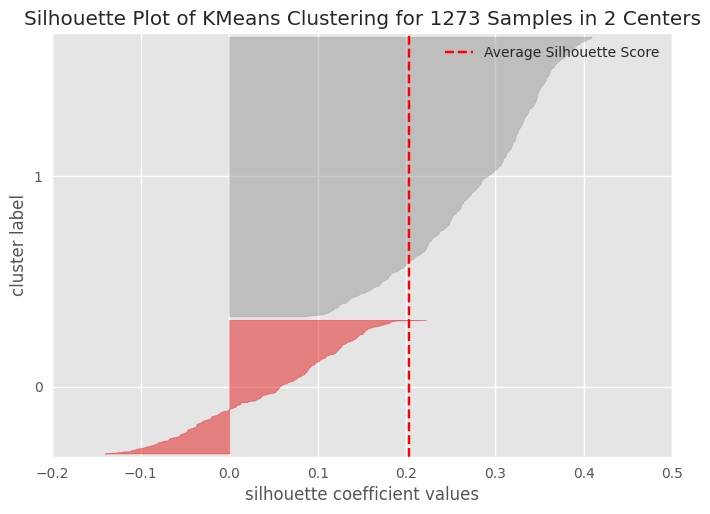

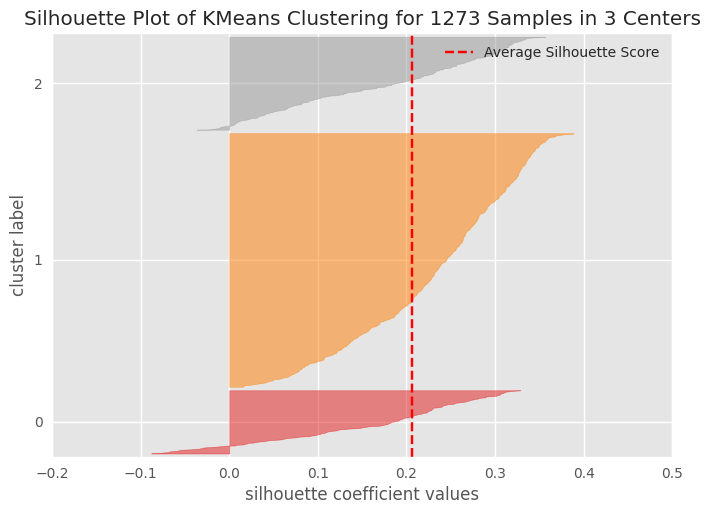

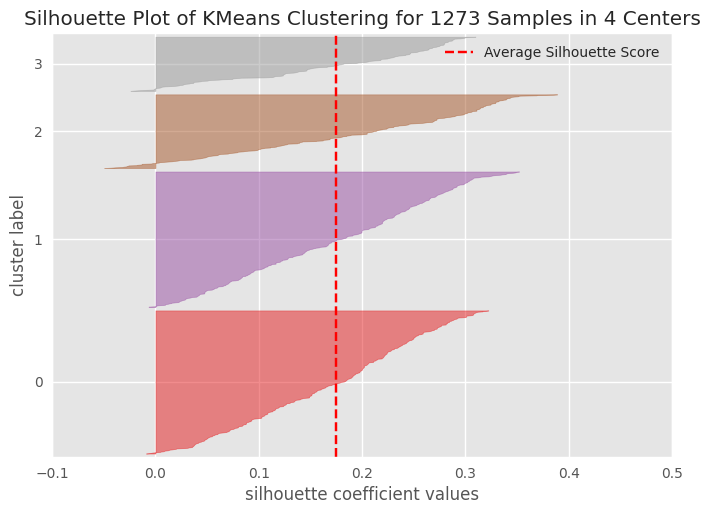

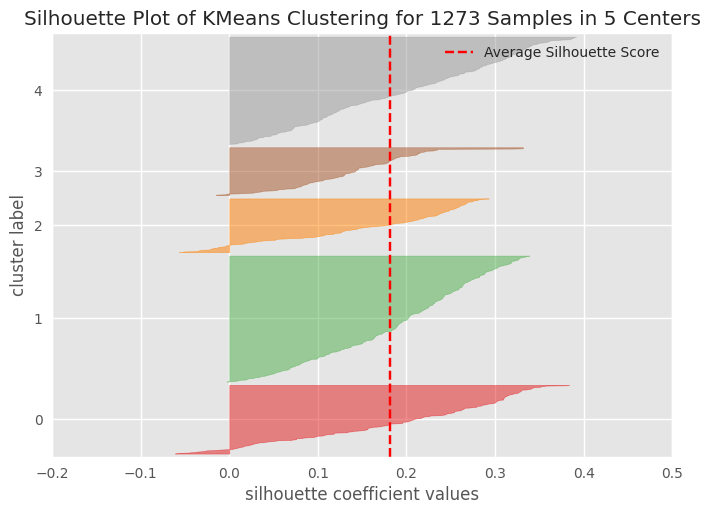

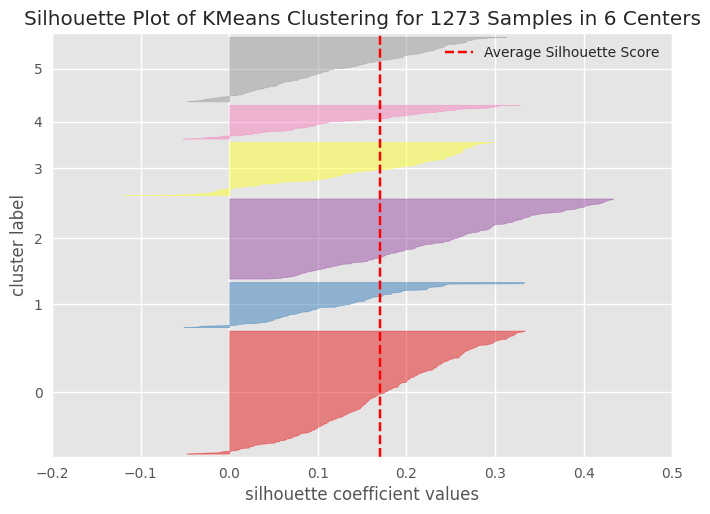

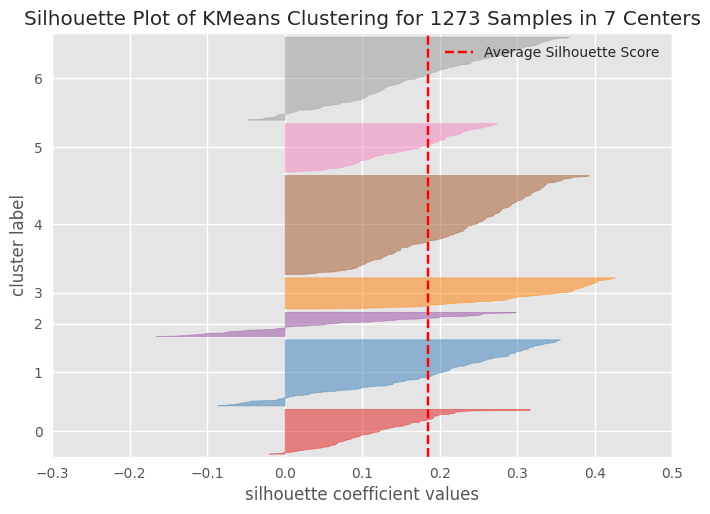

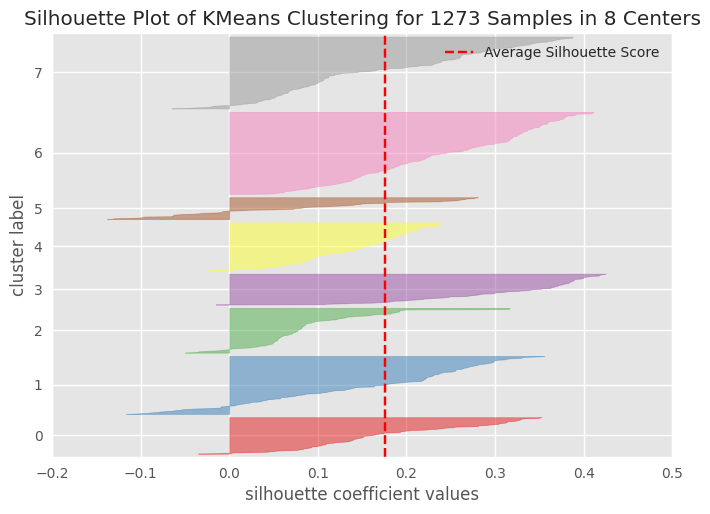

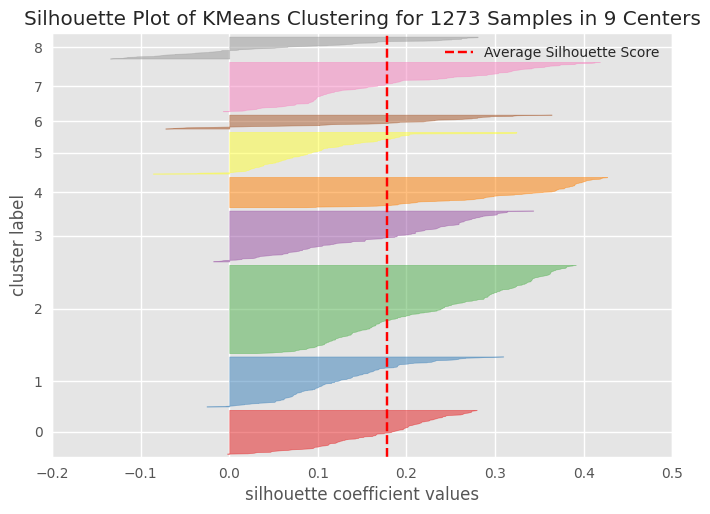

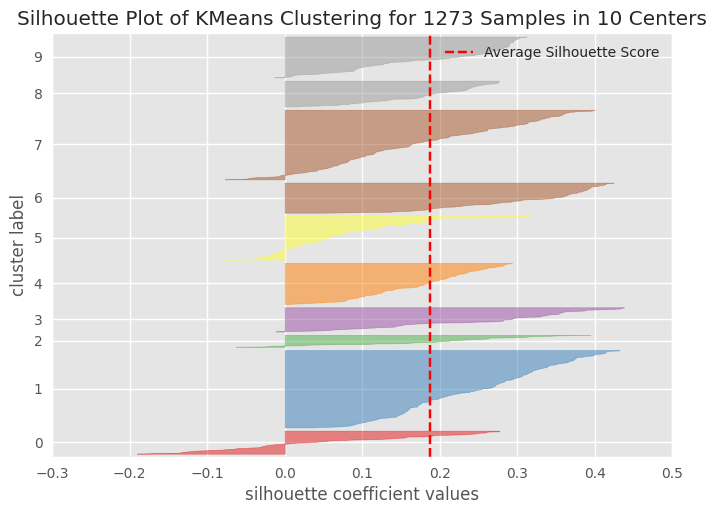

In [ ]:
for i in range(2, 11):
    ss_vis = SilhouetteVisualizer(estimator=KMeans(n_clusters=i))
    ss_vis.fit(X)
    ss_vis.show()
    plt.show()

In [ ]:
def Plot_Decision_Boundary(X, n_clusters):
    """
    Steps Involved:
    1. Fit KMeans clustering to the data.
    2. Apply dimensionality reduction, such as PCA, to reduce the data to 2 dimensions for visualization purposes.
    3. Generate a meshgrid covering the range of the reduced data.
    4. Predict the cluster labels for each point on the meshgrid.
    5. Plot the decision boundary and the data points.
    """
    kmean = KMeans(n_clusters=n_clusters)
    pca = PCA(n_components=2)
    reduced_x = pca.fit_transform(X)
    kmean.fit(reduced_x)

    h = 0.02
    x_min, x_max = reduced_x[:, 0].min() - 1, reduced_x[:, 0].max() + 1
    y_min, y_max = reduced_x[:, 1].min() - 1, reduced_x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict cluster labels for each point on the meshgrid
    Z = kmean.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Set figure Size
    plt.figure(figsize=(15, 8))
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap="viridis")

    # Plot data points
    plt.scatter(reduced_x[:, 0], reduced_x[:, 1], c=kmean.labels_, edgecolors='k')

    # Plot cluster centers
    centers = kmean.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, label='Cluster Centers')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    plt.show()

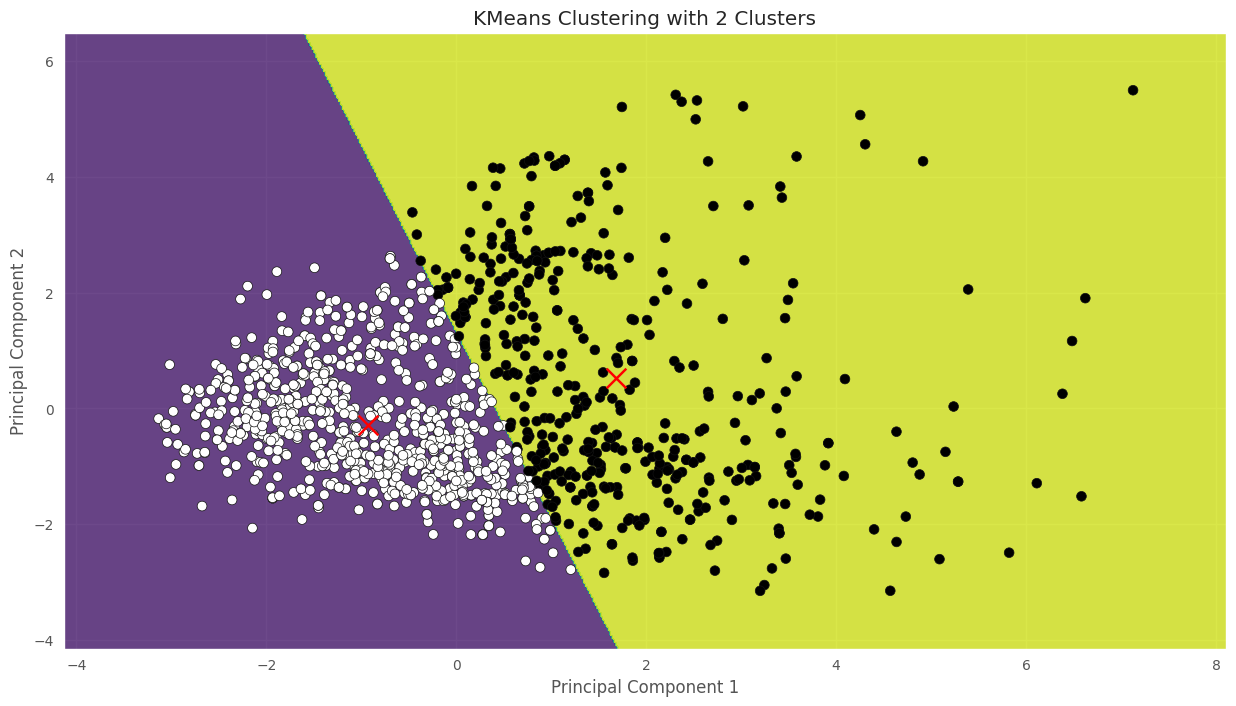

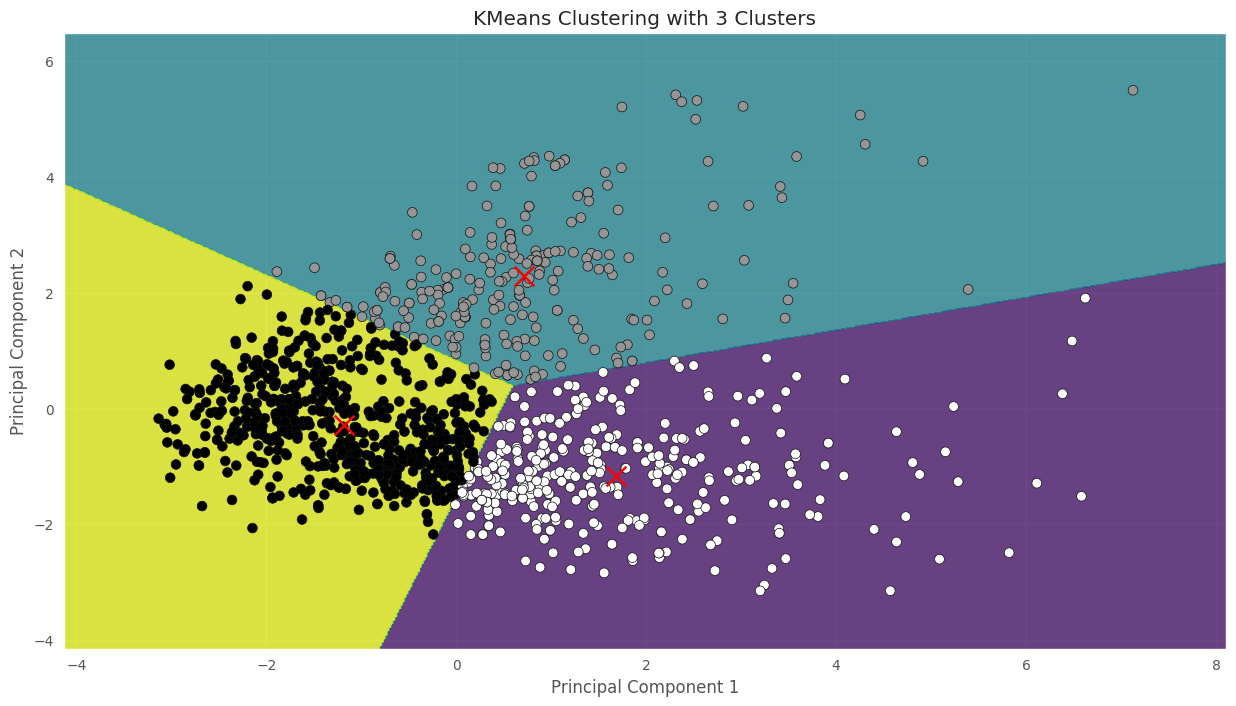

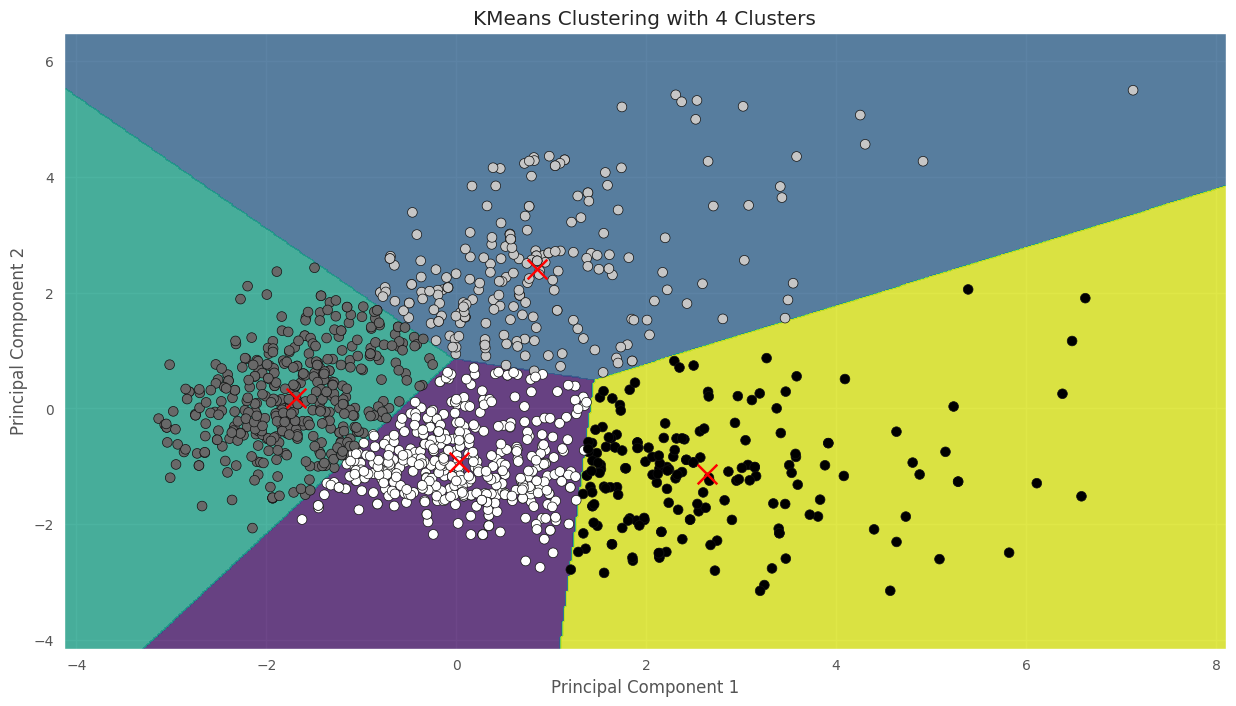

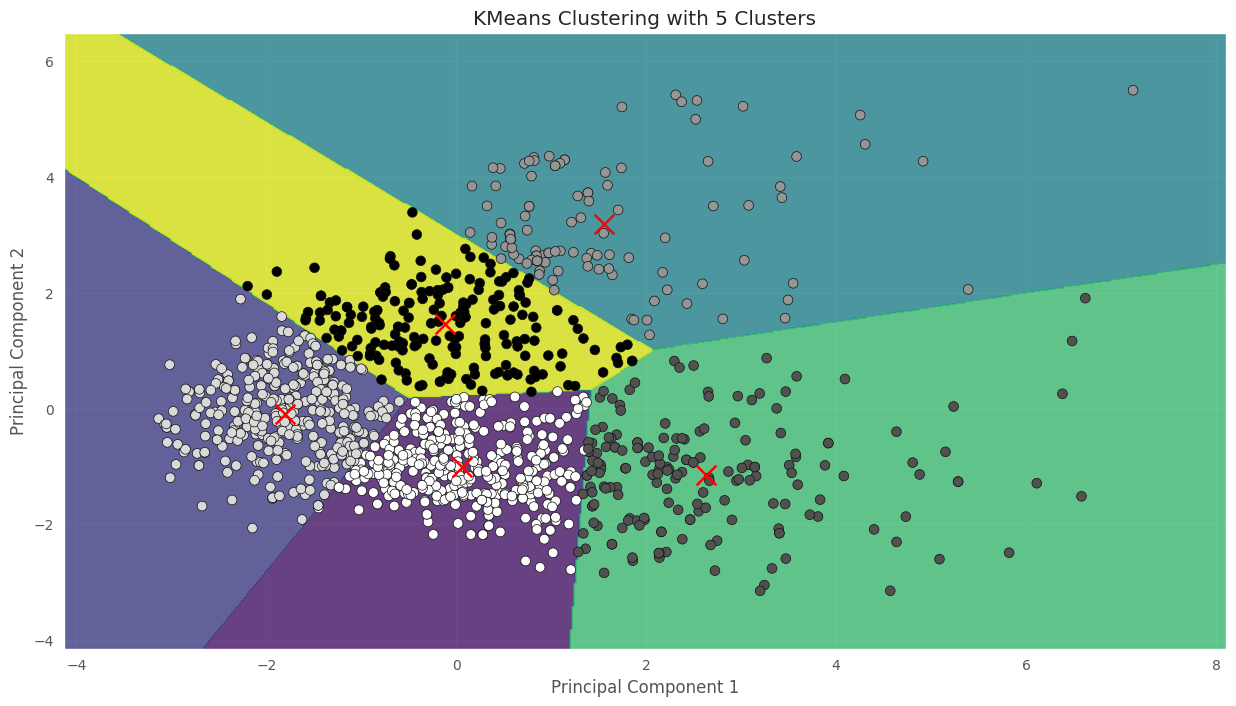

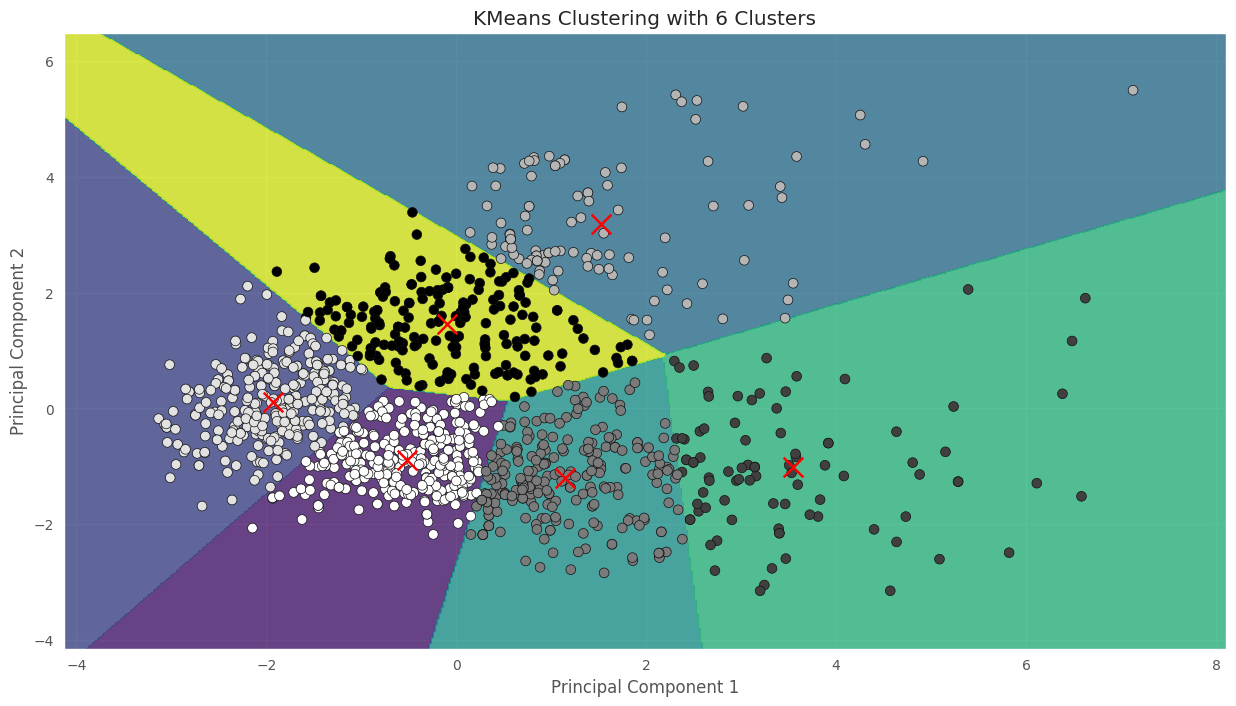

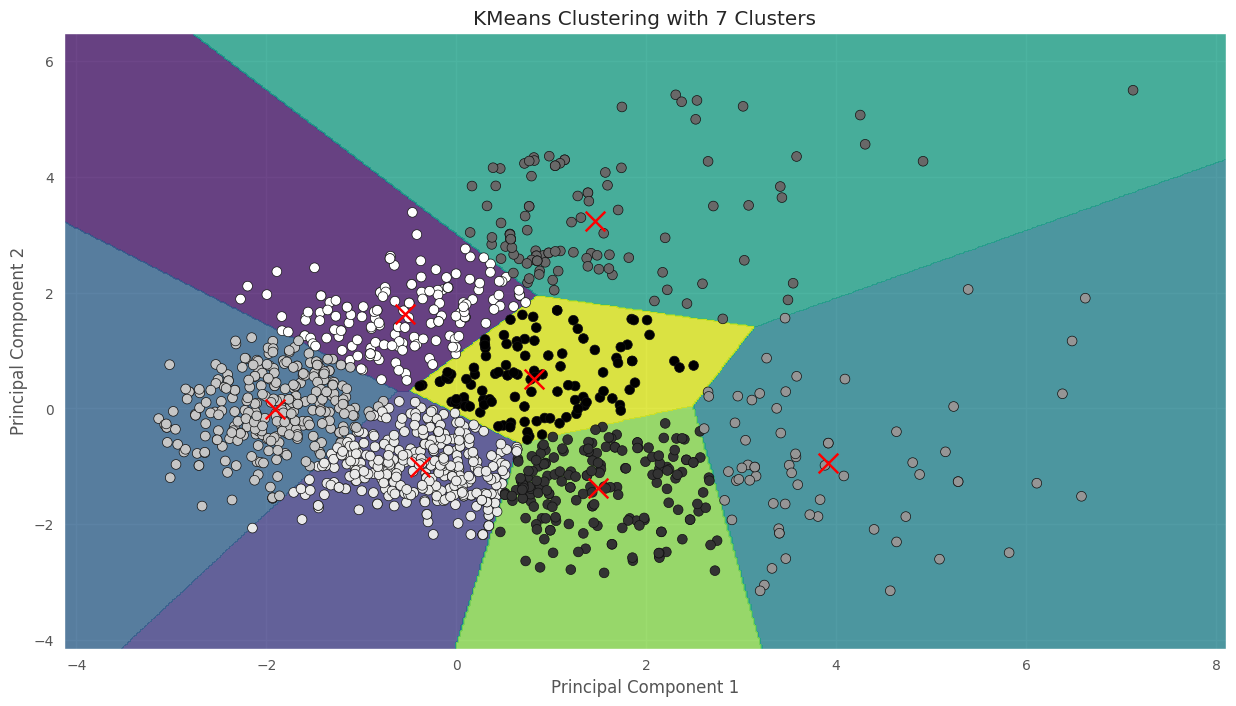

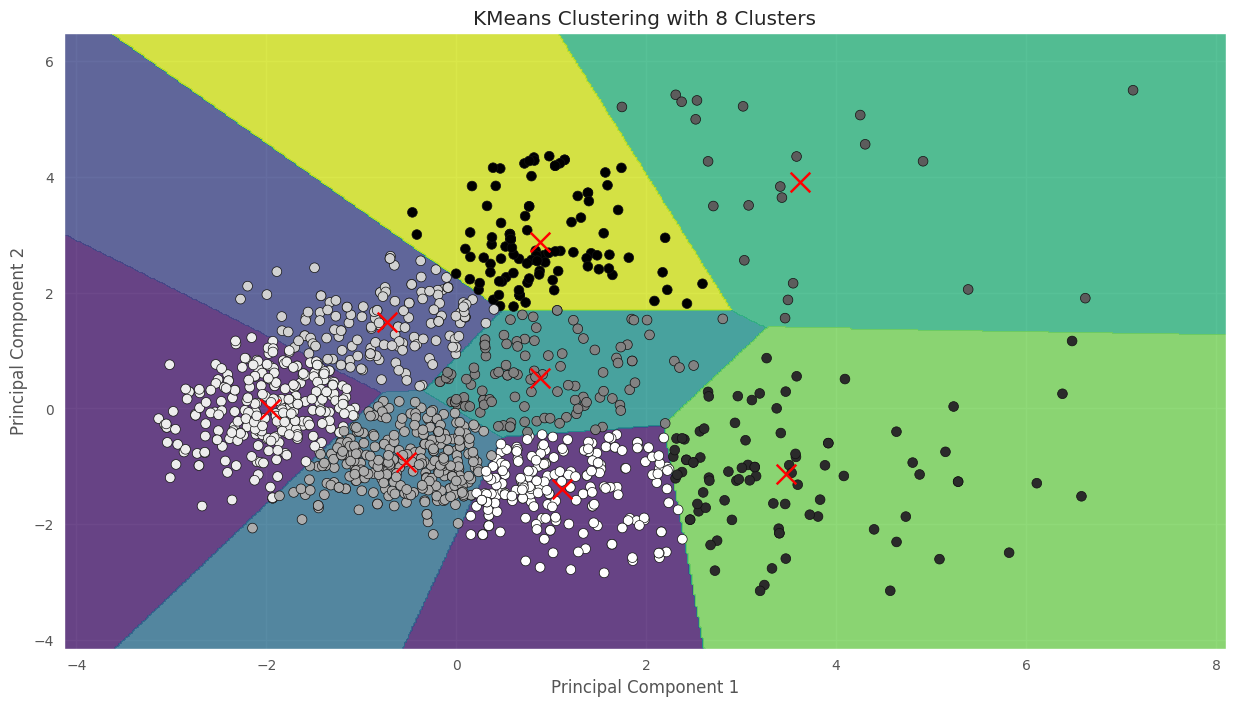

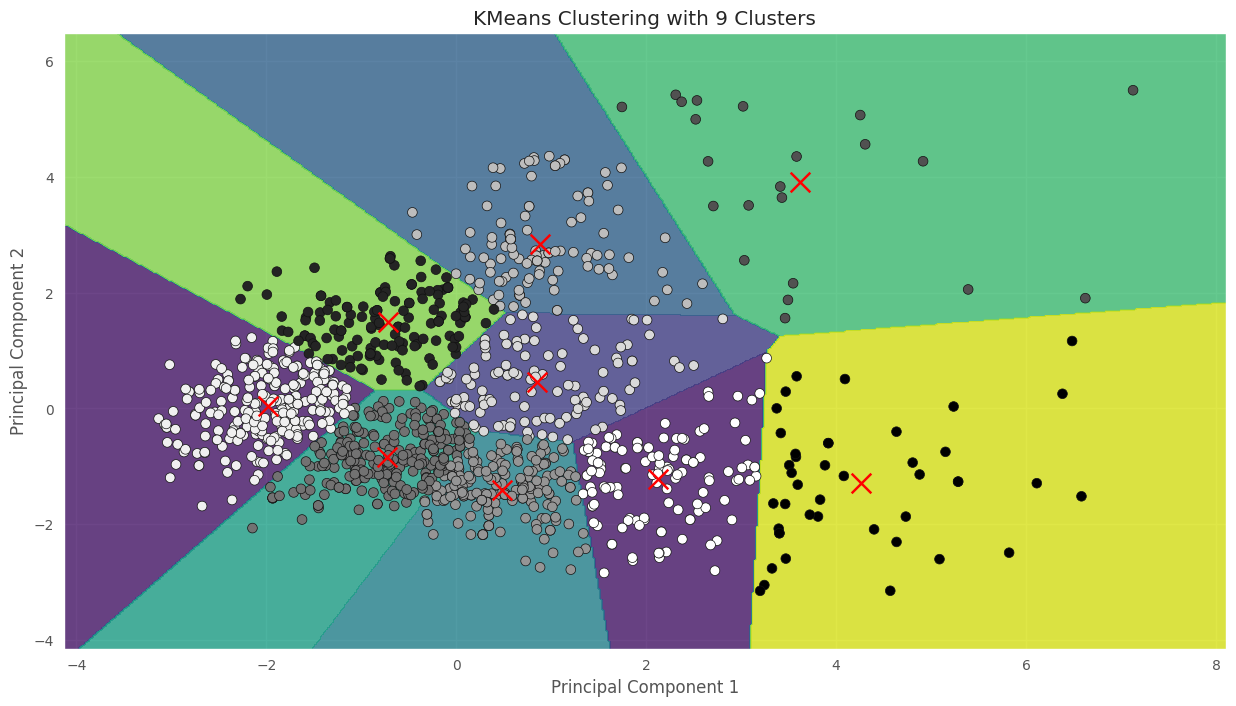

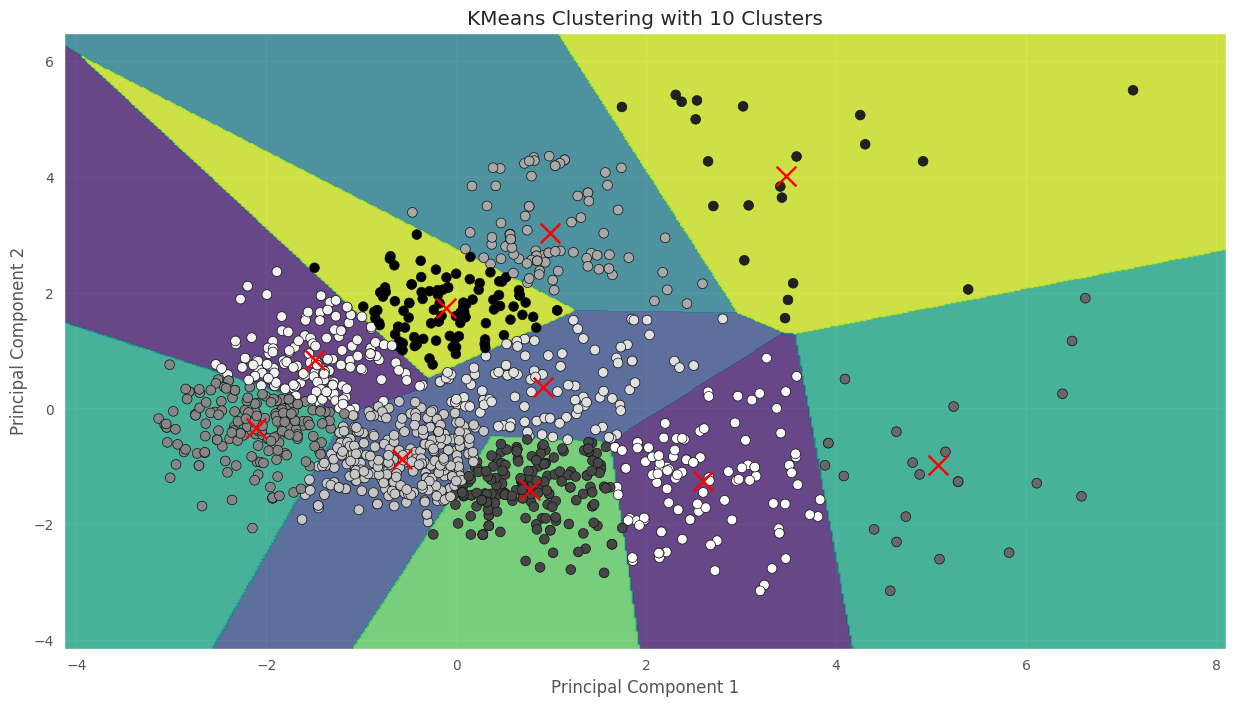

In [ ]:
for i in range(2, 11):
    Plot_Decision_Boundary(X, i)

In [ ]:
cluster_X = data.copy()

cluster_X["Clusters"] = KMeans(n_clusters=5).fit_predict(X)

In [ ]:
cluster_X[cluster_X["Clusters"] == 0]

Company   TypeName  Ram  Weight      Price  TouchScreen  Ips         Ppi  \
8       Asus  Ultrabook   16    1.30  11.285443            0    0  157.350512   
9       Acer  Ultrabook    8    1.60  10.621952            0    1  157.350512   
16      Dell   Notebook    8    2.20  10.588945            0    0  141.211998   
20      Asus    Netbook    2    0.98   9.232535            0    0  135.094211   
24        HP  Ultrabook    8    1.91  10.466285            0    0  141.211998   
...      ...        ...  ...     ...        ...          ...  ...         ...   
1251  Lenovo   Notebook    6    2.40  10.319441            0    0  141.211998   
1252  Lenovo   Notebook    8    1.90  10.952842            0    1  157.350512   
1260    Asus  Ultrabook    8    1.20  10.567235            0    1  165.632118   
1267      HP    Netbook    2    1.17   9.317895            0    0  135.094211   
1271  Lenovo   Notebook    2    1.50   9.409283            0    0  111.935204   

                  Cpu_brand  HDD  SSD Gpu_brand       Os  Clusters  
8             Intel Core i7    0  512    Nvidia  Windows         0  
9             Intel Core i5    0  256     Intel  Windows         0  
16            Intel Core i7    0  256       AMD  Windows         0  
20    Other Intel Processor    0    0     Intel  Windows         0  
24            Intel Core i7    0  256     Intel  Windows         0  
...                     ...  ...  ...       ...      ...       ...  
1251          Intel Core i3    0  128    Nvidia  Windows         0  
1252          Intel Core i5    0  256     Intel  Windows         0  
1260  Other Intel Processor    0  512     Intel  Windows         0  
1267  Other Intel Processor    0    0     Intel  Windows         0  
1271  Other Intel Processor    0    0     Intel  Windows         0  

[399 rows x 14 columns]

In [ ]:
cluster_X[cluster_X["Clusters"] == 1]

Company            TypeName  Ram  Weight      Price  TouchScreen  Ips  \
19         Dell           Ultrabook    8   1.220  10.862093            1    1   
23         Dell  2 in 1 Convertible    8   1.620  10.683645            1    0   
33         Dell           Ultrabook   16   1.200  11.508720            1    0   
50       Lenovo  2 in 1 Convertible    4   0.690   9.740752            1    1   
70    Microsoft           Ultrabook    4   1.252  10.968576            1    0   
...         ...                 ...  ...     ...        ...          ...  ...   
1242       Dell  2 in 1 Convertible   16   2.770  11.470547            1    0   
1248       Dell  2 in 1 Convertible    8   1.240  11.478299            1    0   
1259     Lenovo  2 in 1 Convertible    4   1.800  10.700607            1    0   
1269     Lenovo  2 in 1 Convertible    4   1.800  10.433899            1    1   
1270     Lenovo  2 in 1 Convertible   16   1.300  11.288115            1    1   

             Ppi              Cpu_brand  HDD  SSD Gpu_brand       Os  Clusters  
19    165.632118          Intel Core i5    0  128     Intel  Windows         1  
23    165.632118          Intel Core i5    0  256     Intel  Windows         1  
33    276.053530          Intel Core i7    0  512     Intel  Windows         1  
50    224.173809  Other Intel Processor    0    0     Intel   Others         1  
70    200.842560          Intel Core i5    0  128     Intel  Windows         1  
...          ...                    ...  ...  ...       ...      ...       ...  
1242  127.335675          Intel Core i7    0  512    Nvidia  Windows         1  
1248  276.053530          Intel Core i5    0  256     Intel  Windows         1  
1259  157.350512          Intel Core i5    0  128     Intel  Windows         1  
1269  157.350512          Intel Core i7    0  128     Intel  Windows         1  
1270  276.053530          Intel Core i7    0  512     Intel  Windows         1  

[170 rows x 14 columns]

In [ ]:
cluster_X[cluster_X["Clusters"] == 2]

Company   TypeName  Ram  Weight      Price  TouchScreen  Ips         Ppi  \
0      Apple  Ultrabook    8    1.37  11.175755            0    1  226.983005   
1      Apple  Ultrabook    8    1.34  10.776777            0    0  127.677940   
2         HP   Notebook    8    1.86  10.329931            0    0  141.211998   
3      Apple  Ultrabook   16    1.83  11.814476            0    1  220.534624   
4      Apple  Ultrabook    8    1.37  11.473101            0    1  226.983005   
...      ...        ...  ...     ...        ...          ...  ...         ...   
1241    Acer   Notebook    4    2.40   9.866653            0    0  100.454670   
1247  Lenovo   Notebook    8    2.30  10.326447            0    1  141.211998   
1249    Dell   Notebook    4    2.20   9.756305            0    0  100.454670   
1262    Acer   Notebook    4    2.40   9.641988            0    0  100.454670   
1266    Dell   Notebook    8    2.30  10.667632            0    0  100.454670   

                  Cpu_brand   HDD  SSD Gpu_brand      Os  Clusters  
0             Intel Core i5     0  128     Intel     Mac         2  
1             Intel Core i5     0    0     Intel     Mac         2  
2             Intel Core i5     0  256     Intel  Others         2  
3             Intel Core i7     0  512       AMD     Mac         2  
4             Intel Core i5     0  256     Intel     Mac         2  
...                     ...   ...  ...       ...     ...       ...  
1241          Intel Core i3   500    0     Intel  Others         2  
1247          Intel Core i5     0  256     Intel  Others         2  
1249  Other Intel Processor   500    0     Intel  Others         2  
1262  Other Intel Processor   500    0     Intel  Others         2  
1266          Intel Core i7  1000    0       AMD  Others         2  

[150 rows x 14 columns]

In [ ]:
cluster_X[cluster_X["Clusters"] == 3]

Company  TypeName  Ram  Weight      Price  TouchScreen  Ips         Ppi  \
5       Acer  Notebook    4    2.10   9.967026            0    0  100.454670   
13      Dell  Notebook    4    2.20  10.187967            0    0  141.211998   
25      Dell  Notebook    4    2.30  10.012572            0    0  100.454670   
27      Dell  Notebook    8    2.20  10.660173            0    0  141.211998   
29        HP  Notebook    8    2.50  10.773501            0    0  127.335675   
...      ...       ...  ...     ...        ...          ...  ...         ...   
1261    Dell  Notebook    6    2.30  10.104611            0    0  100.454670   
1263    Dell  Notebook    2    2.20   9.913097            0    0  100.454670   
1265      HP  Notebook    6    2.04  10.285461            0    0  141.211998   
1268    Asus  Notebook    4    2.20  10.555257            0    0  100.454670   
1272      HP  Notebook    6    2.19  10.614129            0    0  100.454670   

                  Cpu_brand   HDD  SSD Gpu_brand       Os  Clusters  
5             AMD Processor   500    0       AMD  Windows         3  
13            Intel Core i3     0  256       AMD  Windows         3  
25            Intel Core i3  1000    0     Intel  Windows         3  
27            Intel Core i5     0  256       AMD  Windows         3  
29            Intel Core i5  1000    0    Nvidia  Windows         3  
...                     ...   ...  ...       ...      ...       ...  
1261          Intel Core i3  1000    0     Intel  Windows         3  
1263  Other Intel Processor   500    0     Intel  Windows         3  
1265          AMD Processor     0    0       AMD  Windows         3  
1268          Intel Core i7   500    0    Nvidia  Windows         3  
1272          Intel Core i7  1000    0       AMD  Windows         3  

[325 rows x 14 columns]

In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(opt_model, f)

## Eddy